# Convolutional Neural Networks

## Import all libs

In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

from sklearn.model_selection import train_test_split

## Download MNIST

In [2]:
data = datasets.MNIST(
    root = 'data/mnist',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data/mnist', 
    train = False, 
    transform = ToTensor()
)

In [3]:
len(data)

60000

## Let's quickly inspect the data

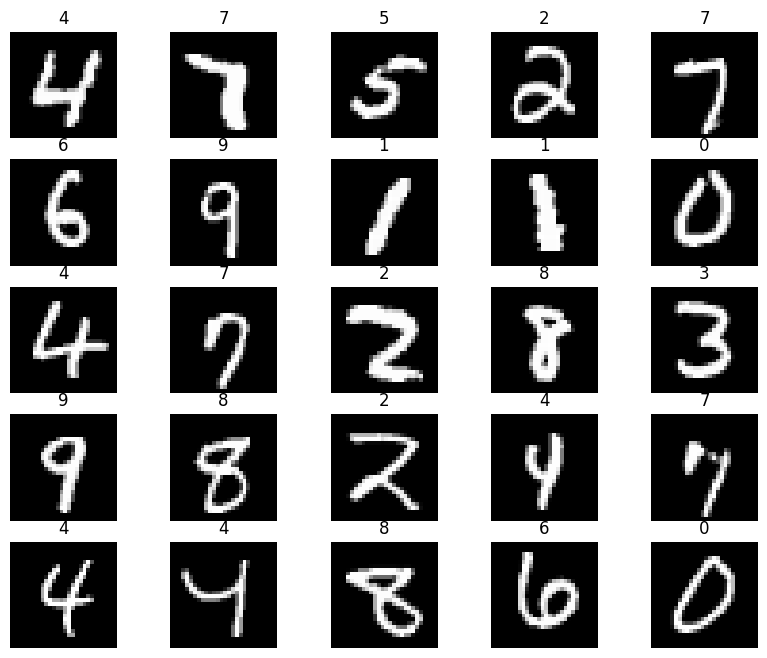

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Let's split the data into training and validation

In [5]:
train_set, val_set = torch.utils.data.random_split(data, [50000, 10000])

## Dataloader helps us sample a mini_batch
Mini-batches are a way to train an epoch on a smaller random sample of the training data to avoid overfitting and improve the performance with large datasets.

In [6]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_set,
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'validation'  : DataLoader(val_set, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1),
    'test'  : DataLoader(test_data, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1),
}

## Now it's time to design a Convolutional Neural Network

Parameters

**in_channels (int)** — Number of channels in the input image

**out_channels (int)** — Number of channels produced by the convolution

**kernel_size (int or tuple)** — Size of the convolving kernel

**stride (int or tuple, optional)** — Stride of the convolution. Default: 1

**padding (int or tuple, optional)** — Zero-padding added to both sides of the input. Default: 0

**padding_mode (string, optional)** — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. 
Default: ‘zeros’

**groups (int, optional)** — Number of blocked connections from input channels to output channels. Default: 1

**bias (bool, optional)** — If True, adds a learnable bias to the output. Default: True

In [7]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(      
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.fully_connected = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.fully_connected(x)
        return output    # return x for visualization

## We can get overall info on the network we just created

In [8]:
conv_nn = CNN()
print(conv_nn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Linear(in_features=1568, out_features=10, bias=True)
)


## Loss function and optimizer

Now we define the loss function. We coose cross entropy since we want a categorical output.
We also choose an optimizer. Optimizer is the algorithm that changes the weights depending on the loss function gradient dependent on the NN parameters. We take Adam since it's better than SGD.

In [9]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.01)


## Now we make a loop where we train the network

In [10]:
def train(num_epochs, ann, loaders):
    min_valid_loss = np.inf
        
    if torch.cuda.is_available():
        print('Running on GPU')
        ann.cuda()

    for epoch in range(num_epochs):

        # Train the model
        epoch_train_loss = 0
        # This line tells our ANN that it's in the training mode
        # This will become relevant when we introduce layers that behave
        # differently in training and deployment/evaluation modes
        ann.train()
        for i, (images, labels) in enumerate(loaders['train']):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            
            # forward pass
            output = ann(images) 
            
            loss = loss_f(output, labels)
            epoch_train_loss += loss.item()

            # clear gradients for this training step   
            optimizer.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                

        # Validate the model
        epoch_val_loss = 0
        ann.eval()
        for images_v, labels_v in loaders['validation']:
            if torch.cuda.is_available():
                images_v, labels_v = images_v.cuda(), labels_v.cuda()
            output = ann(images_v)
            loss_v = loss_f(output, labels_v)
            epoch_val_loss += loss_v.item()

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
        print('-------------------')
        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
            min_valid_loss = epoch_val_loss
            # Saving State Dict
            torch.save(ann.state_dict(), 'saved_model.pth')

In [11]:
train(10, conv_nn, loaders)

Epoch 1
Training Loss: 0.16876935948152094
Validation Loss: 0.07028127872385084
-------------------
Validation Loss Decreased(inf--->7.028127872385085) 	 Saving The Model
Epoch 2
Training Loss: 0.05832998692104593
Validation Loss: 0.0629034019773826
-------------------
Validation Loss Decreased(7.028127872385085--->6.29034019773826) 	 Saving The Model
Epoch 3
Training Loss: 0.05154468925332185
Validation Loss: 0.10295232542790472
-------------------
Epoch 4
Training Loss: 0.04762773996242322
Validation Loss: 0.08694806819781661
-------------------
Epoch 5
Training Loss: 0.04238943870662479
Validation Loss: 0.07188210720196367
-------------------
Epoch 6
Training Loss: 0.04064708870451432
Validation Loss: 0.08939417726069224
-------------------
Epoch 7
Training Loss: 0.04244945188582642
Validation Loss: 0.06852660061325878
-------------------
Epoch 8
Training Loss: 0.036861397112807025
Validation Loss: 0.09232867652157438
-------------------
Epoch 9
Training Loss: 0.03875187131781422
Va

In [12]:
def evaluate(model, test_loader):
    if torch.cuda.is_available():
        model.cuda()
        model.eval()
    correct = 0 
    for test_imgs, test_labels in test_loader:
        if torch.cuda.is_available():
            test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*100)))                           

## Now we test the model

In [13]:
saved_nn = CNN()
saved_nn.load_state_dict(torch.load('saved_model.pth'))
evaluate(saved_nn, loaders['test'])

Test accuracy:0.985% 
